In [46]:
import os
import pandas as pd
import xarray as xr
import glob
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset, date2num, num2date
import datetime as dt

In [188]:
# Create latlon.csv files for 516 glacier centroid coordinates

csv_files = sorted(glob.glob('/home/clara/rahu_data/JULES_OGGM/historical_00_18/*_latlon.csv'))

dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

#pd.concat(dfs).to_csv(('/home/clara/rahu_data/JULES_OGGM/historical_00_18/latlon_516.csv'), index=False)

In [2]:
# Read glacier melt files and check number of glaciers = 516 (not 532, need to check with Jon if this is ok...) # 05/12/2023 CGJ
df_dca_melt=pd.read_csv('/home/clara/rahu_data/JULES_OGGM/historical_00_18/dist_calca_urubamba_melt_m3s-1.csv')
df_hua_melt=pd.read_csv('/home/clara/rahu_data/JULES_OGGM/historical_00_18/dist_huarocondo_melt_m3s-1.csv')
df_ms_melt=pd.read_csv('/home/clara/rahu_data/JULES_OGGM/historical_00_18/dist_machupicchu_sud_melt_m3s-1.csv')
df_stc_melt=pd.read_csv('/home/clara/rahu_data/JULES_OGGM/historical_00_18/dist_santa_teresa_central_melt_m3s-1.csv')
df_sts_melt=pd.read_csv('/home/clara/rahu_data/JULES_OGGM/historical_00_18/dist_santa_teresa_sud_melt_m3s-1.csv')
df_cn_melt=pd.read_csv('/home/clara/rahu_data/JULES_OGGM/historical_00_18/prov_canchis_norte_melt_m3s-1.csv')
df_cs_melt=pd.read_csv('/home/clara/rahu_data/JULES_OGGM/historical_00_18/prov_canchis_sud_melt_m3s-1.csv')
df_un_melt=pd.read_csv('/home/clara/rahu_data/JULES_OGGM/historical_00_18/prov_urubamba_norte_melt_m3s-1.csv')


len(df_dca_melt.columns) + len(df_hua_melt.columns) + len(df_ms_melt.columns) + len(df_stc_melt.columns) + len(df_sts_melt.columns) + len(df_cn_melt.columns) + len(df_cs_melt.columns) + len(df_un_melt.columns) -8
# So there should be 516 glaciers here too

516

In [3]:
# Generate yearly melt file
csv_files = sorted(glob.glob('/home/clara/rahu_data/JULES_OGGM/historical_00_18/*_melt_m3s-1.csv')) # important so that we always follow the same order
# m3s-1 mean daily melt file

dfs = []
for file in csv_files:
    df_ca_melt = pd.read_csv(file)
    df_ca_melt = df_ca_melt.rename(columns={"Unnamed: 0":"date"})
    df_ca_melt['date'] = pd.to_datetime(df_ca_melt['date'])
    s = df_ca_melt.select_dtypes(include=[np.number]) * 60*60*24 # converting from m3/s to m3/d
    df_ca_melt[s.columns] = s
    df_ca_melt = df_ca_melt.groupby(df_ca_melt.date.dt.year, dropna=True)[list(df_ca_melt.columns)[1:]].sum() # convert from m3/d to m3/year
    df_ca_melt = df_ca_melt.transpose()
    dfs.append(df_ca_melt)

# pd.concat(dfs).to_csv('/home/clara/rahu_data/JULES_OGGM/historical_00_18/yearly_melt.csv') # run to overwrite the file

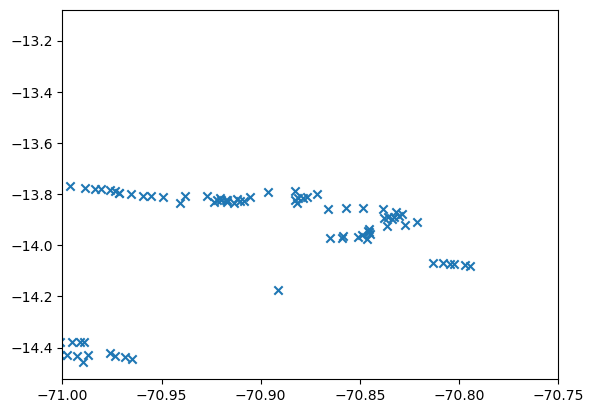

In [4]:
# Check the glacier locations to do sanity checks for cells where the sum will only consider one glacier contribution, this is point RGI60-16.01093n
# LAT -14.174576
# LON -70.891423
# number 426 in python dataframes

#pd.set_option('display.max_rows', None)
latlon = pd.read_csv("/home/clara/rahu_data/JULES_OGGM/historical_00_18/latlon.csv")
lat = latlon.iloc[:,1]
lon = latlon.iloc[:,2]
plt.scatter(lon,lat, marker='x')
plt.xlim(-71,-70.75)

np.where( (latlon.iloc[:,1]<-14) & (latlon.iloc[:,1]>-14.2) & (latlon.iloc[:,2]>-70.9) & (latlon.iloc[:,2]<-70.87) ) #(array([426]),)
latlon.iloc[426]
# RGI_ID       RGI60-16.01093n
# Latitude          -14.174576
# Longitude         -70.891423
# Name: 426, dtype: object
RGI60_melt = pd.read_csv("/home/clara/rahu_data/JULES_OGGM/historical_00_18/yearly_melt.csv").iloc[426] # read yearly melt contributions at that glacier point

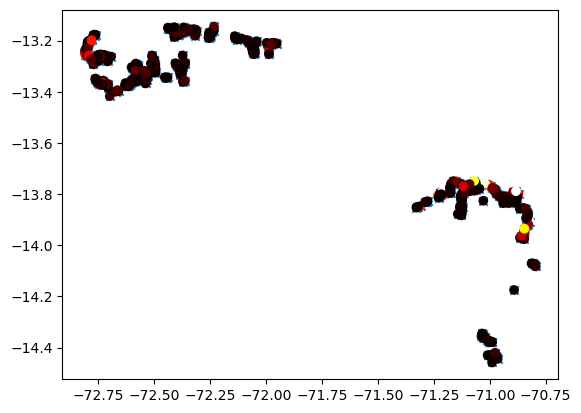

In [118]:
latlon = pd.read_csv("/home/clara/rahu_data/JULES_OGGM/historical_00_18/latlon.csv")
yearly_melt = pd.read_csv("/home/clara/rahu_data/JULES_OGGM/historical_00_18/yearly_melt.csv")
yearly_melt.iloc[:,1]
lat = latlon.iloc[:,1]
lon = latlon.iloc[:,2]
melt_2000 = yearly_melt.iloc[:,1]
plt.scatter(lon,lat, marker='x')
plt.scatter(lon,lat,c=melt_2000, cmap='hot')
# useful plot to check assembling in R was done properly

In [113]:
yearly_melt = pd.read_csv("/home/clara/rahu_data/JULES_OGGM/historical_00_18/yearly_melt.csv")
yearly_melt.iloc[:,1]

0      5.810077e+05
1      1.155077e+04
2      4.526526e+05
3      8.195874e+05
4      3.891759e+04
           ...     
511    6.929124e+05
512    1.392769e+06
513    1.159786e+05
514    2.085811e+04
515    1.160830e+05
Name: 2000, Length: 516, dtype: float64

Run this cell in R - this will produce 3d matrix of yearly melt at JULES grid locations

/home/clara/rahu_data/JULES_OGGM/historical_00_18/glacier_files_manip.r

library(raster)
library(dplyr)
library(magrittr)
library(MASS)
pts <- read.csv("/home/clara/rahu_data/JULES_OGGM/historical_00_18/latlon.csv")
pts2 <- pts[,2:3]
pts2 <- relocate(pts2, 'Longitude')
pts2 <- as.matrix(pts2)

melt_oggm <- read.csv('/home/clara/rahu_data/JULES_OGGM/historical_00_18/yearly_melt.csv')
r <- raster("/home/clara/rahu_data/netcdf/gridcell_area_rahu.nc")

DF <- array(data=NA, dim=c(75,102,19))
for (year in 1:19) {
    melt <- melt_oggm[,year+1]
    rnew <- rasterize(pts2, r, melt, na.rm=TRUE, fun=sum)
    dfmelt <- as.matrix(rnew, xy=TRUE)
    DF[,,year] <- dfmelt
}

save(DF, file="/home/clara/rahu_data/JULES_OGGM/yearly_melt_gridded.rda")

/usr/lib/python3/dist-packages/matplotlib/image.py:479: RuntimeWarning: invalid value encountered in subtract
  A_scaled -= a_min


<AxesSubplot:xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

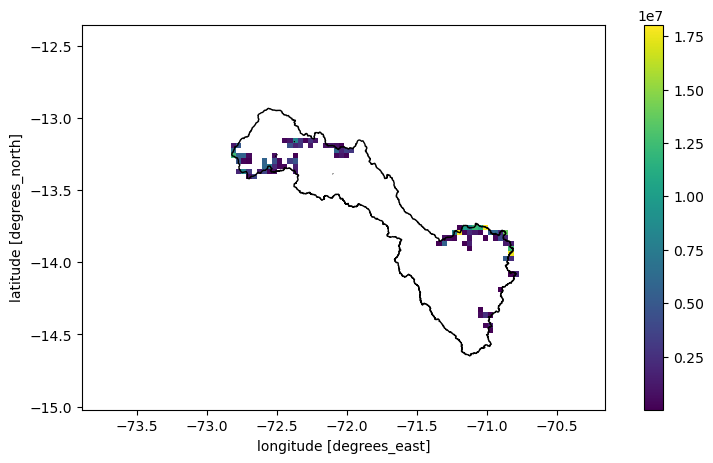

In [5]:
import pyreadr
import geopandas as gdp

nc = xr.open_dataset("/home/clara/project/rahu/jules-output/u-cj531/JULES_vn6.1.S2.daily_hydrology.1981.2D.nc")
shpfile = gdp.read_file("/home/clara/rahu_data/VUB_studies/VUB_full/cuenca_vilcanota_final.shp")
shpfile = shpfile.to_crs(epsg=4326)

melt_year = pyreadr.read_r('/home/clara/rahu_data/JULES_OGGM/yearly_melt_gridded.rda')
melt_year = melt_year['DF']
melt_year = melt_year.rename(({'dim_0':'lat','dim_1':'lon','dim_2':'year'}))
melt_1 = xr.DataArray(
    data=melt_year[:,:,1],
    dims=["lat","lon"],
    coords=dict(
        lon=nc['lon'],
        lat=nc['lat']
    ),
)

f, ax = plt.subplots(figsize=(10,5))
melt_1.plot.imshow(ax=ax)
shpfile.plot(ax=ax, facecolor="none" )

In [6]:
# Check values are correct
# DF[51,81,:] should be equal to the yearly melt contributions at glacier point RGI60-16.01093n identified earlier
melt_year[51,81,:]

# array([40408.27266457, 41814.42222046, 41610.20799135, 37263.69474105,
#       36822.79395619, 37790.74510131, 35167.11155265, 34449.43946025,
#       30129.83031629, 29704.65113906, 30857.60605879, 30327.91783969,
#       26156.99477061, 26585.3123884 , 22961.41186233, 22320.75059224,
#       19533.10484788, 16626.82371934,     0.        ])

RGI60_melt

Unnamed: 0    RGI60-16.01093n
2000             40408.272665
2001              41814.42222
2002             41610.207991
2003             37263.694741
2004             36822.793956
2005             37790.745101
2006             35167.111553
2007              34449.43946
2008             30129.830316
2009             29704.651139
2010             30857.606059
2011              30327.91784
2012             26156.994771
2013             26585.312388
2014             22961.411862
2015             22320.750592
2016             19533.104848
2017             16626.823719
2018                      0.0
Name: 426, dtype: object

In [98]:
# Create nc file for glacier melt
MELT = melt_year
nc = xr.open_dataset("/home/clara/project/rahu/jules-output/u-cj531/JULES_vn6.1.S2.daily_hydrology.1980.2D.nc")
LAT = nc['lat']
LON = nc['lon']
dates = pd.date_range(start=dt.datetime(2000,1,1,0),periods=19,freq='AS-JAN')
dates = dates.to_pydatetime()
#dates = (np.arange(np.datetime64("2000,1,1,0"), np.datetime64("2019"), np.timedelta64(1, "Y")))
#TIME = np.arange(19) * 366
#TIME = np.array((np.arange(np.datetime64("2000"), np.datetime64("2019"), np.timedelta64(1, "Y"))), dtype=object)
ncfile = Dataset("/home/clara/rahu_data/JULES_OGGM/historical_00_18/melt_year2.nc", mode="w", format="NETCDF4")
lat_dim = ncfile.createDimension('lat', 75)
lon_dim = ncfile.createDimension('lon', 102)
time_dim = ncfile.createDimension('time', 19)
lat = ncfile.createVariable('lat', np.float64, ('lat',))
lat.units = 'degrees_north'
lat.long_name = 'latitude'
lon = ncfile.createVariable('lon', np.float64, ('lon',))
lon.units = 'degrees_east'
lon.long_name = 'longitude'
time = ncfile.createVariable('time', np.float64, ('time',))
time.units = 'days since 2000-01-01'
time.long_name = 'time'
time.calendar = 'proleptic_gregorian'
TIME = date2num(dates, time.units)
melt = ncfile.createVariable('melt', np.float64, ('lat','lon','time'))
melt.units = 'm3'
melt.standard_name = 'glacier_melt'
nlats = len(lat_dim)
nlons = len(lon_dim)
ntimes = len(time_dim)
lat[:] = LAT
lon[:] = LON
melt[:,:,:] = MELT
time[:] = TIME
ncfile.close()

/usr/lib/python3/dist-packages/matplotlib/colors.py:1253: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


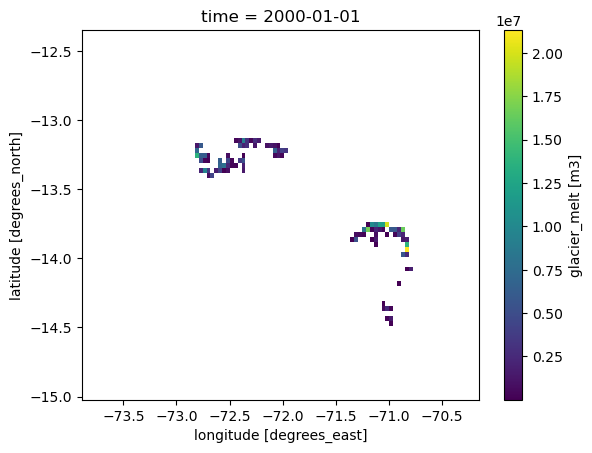

In [119]:
new = xr.open_dataset("/home/clara/rahu_data/JULES_OGGM/historical_00_18/melt_year.nc")
new['melt'][:,:,0].plot()



Now, let's create a .nc file for the percentage of glacier per gridcell area for all years

In [ ]:
# We create the areas.csv file for the glacier points

csv_files = sorted(glob.glob('/home/clara/rahu_data/JULES_OGGM/historical_00_18/*_area_m2.csv'))

dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    df=df.rename(columns={'Unnamed: 0':'Year'})
    df=df.set_index('Year')
    df = df.transpose()
    dfs.append(df)

#pd.concat(dfs).to_csv('/home/clara/rahu_data/JULES_OGGM/historical_00_18/areas.csv') 
pd.read_csv('/home/clara/rahu_data/JULES_OGGM/historical_00_18/areas.csv')

Run this in R code /home/clara/rahu_data/JULES_OGGM/coupling.r

library(raster)
library(dplyr)
library(magrittr)
library(MASS)

pts <- read.csv("/home/clara/rahu_data/JULES_OGGM/historical_00_18/latlon.csv")
pts2 <- pts[,2:3]
pts2 <- relocate(pts2, 'Longitude')
pts2 <- as.matrix(pts2)

area_oggm <- read.csv('/home/clara/rahu_data/JULES_OGGM/historical_00_18/areas.csv')
r <- raster("/home/clara/rahu_data/netcdf/gridcell_area_rahu.nc")

DF <- array(data=NA, dim=c(75,102,19))
for (year in 1:19) {
    area <- area_oggm[,year+1]
    rnew <- rasterize(pts2, r, area, fun=sum, na.rm=TRUE)
    df <- as.matrix(rnew, xy=TRUE)
    DF[,,year] <- df
}

perc <- array(data=NA, dim=c(75,102,19))
for (year in 1:19) {
    for (lat in 1:75) {
        for (lon in 1:102) {
            perc[lat,lon,year] = DF[lat,lon,year]/r[lat,lon,1]
        }
    }
}

save(perc, file="/home/clara/rahu_data/JULES_OGGM/percentage_glacier_per_gridcell_area.rda")


<AxesSubplot:xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

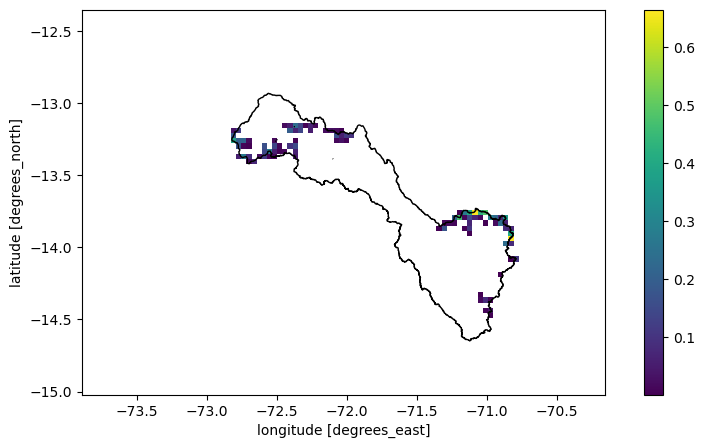

In [148]:
import pyreadr
import geopandas as gdp

nc = xr.open_dataset("/home/clara/project/rahu/jules-output/u-cj531/JULES_vn6.1.S2.daily_hydrology.1981.2D.nc")
shpfile = gdp.read_file("/home/clara/rahu_data/VUB_studies/VUB_full/cuenca_vilcanota_final.shp")
shpfile = shpfile.to_crs(epsg=4326)

perc = pyreadr.read_r('/home/clara/rahu_data/JULES_OGGM/percentage_glacier_per_gridcell_area.rda')
perc = perc['perc']
perc = perc.rename(({'dim_0':'lat','dim_1':'lon','dim_2':'year'}))
perc_1 = xr.DataArray(
    data=perc[:,:,1],
    dims=["lat","lon"],
    coords=dict(
        lon=nc['lon'],
        lat=nc['lat']
    ),
)

f, ax = plt.subplots(figsize=(10,5))
perc_1.plot.imshow(ax=ax)
shpfile.plot(ax=ax, facecolor="none" )

In [176]:
# Let's do the same check as for glacier melt with the gridcell with only one glacier contribution
RGI60_area = pd.read_csv("/home/clara/rahu_data/JULES_OGGM/historical_00_18/areas.csv").iloc[426][:] # read yearly melt contributions at that glacier point
# Check values are correct
# perc[51,81,:] should be equal to the yearly area at glacier point RGI60-16.01093n identified earlier divided by the gridcell area
nc_area = xr.open_dataset("/home/clara/rahu_data/netcdf/gridcell_area_rahu.nc")

perc[51,81,:]

#array([0.00173264, 0.00139481, 0.00131157, 0.00127697, 0.00124536,
#       0.00121781, 0.0011678 , 0.00111716, 0.00105075, 0.00098166,
#       0.00094334, 0.00089644, 0.00084478, 0.00080227, 0.00074639,
#       0.00070056, 0.00064143, 0.00057787, 0.00047707])

nc_area['area'][51,81].values # 15583155.60523129m2 # JULES gridcell area
RGI60_area.tolist()[1:]/nc_area['area'][51,81].values # percentage of grid occupied by glacier each year

#array([0.00173264, 0.00139481, 0.00131157, 0.00127697, 0.00124536,
#       0.00121781, 0.0011678 , 0.00111716, 0.00105075, 0.00098166,
#       0.00094334, 0.00089644, 0.00084478, 0.00080227, 0.00074639,
#       0.00070056, 0.00064143, 0.00057787, 0.00047707])

# Works fine!

array([0.00173264, 0.00139481, 0.00131157, 0.00127697, 0.00124536,
       0.00121781, 0.0011678 , 0.00111716, 0.00105075, 0.00098166,
       0.00094334, 0.00089644, 0.00084478, 0.00080227, 0.00074639,
       0.00070056, 0.00064143, 0.00057787, 0.00047707])

In [178]:
# Create nc file for % of glacier area per gridcell
PERC = perc
nc = xr.open_dataset("/home/clara/project/rahu/jules-output/u-cj531/JULES_vn6.1.S2.daily_hydrology.1980.2D.nc")
LAT = nc['lat']
LON = nc['lon']
dates = pd.date_range(start=dt.datetime(2000,1,1,0),periods=19,freq='AS-JAN')
dates = dates.to_pydatetime()
#dates = (np.arange(np.datetime64("2000,1,1,0"), np.datetime64("2019"), np.timedelta64(1, "Y")))
#TIME = np.arange(19) * 366
#TIME = np.array((np.arange(np.datetime64("2000"), np.datetime64("2019"), np.timedelta64(1, "Y"))), dtype=object)
ncfile = Dataset("/home/clara/rahu_data/JULES_OGGM/historical_00_18/glacier_perc_per_gridcell.nc", mode="w", format="NETCDF4")
lat_dim = ncfile.createDimension('lat', 75)
lon_dim = ncfile.createDimension('lon', 102)
time_dim = ncfile.createDimension('time', 19)
lat = ncfile.createVariable('lat', np.float64, ('lat',))
lat.units = 'degrees_north'
lat.long_name = 'latitude'
lon = ncfile.createVariable('lon', np.float64, ('lon',))
lon.units = 'degrees_east'
lon.long_name = 'longitude'
time = ncfile.createVariable('time', np.float64, ('time',))
time.units = 'days since 2000-01-01'
time.long_name = 'time'
time.calendar = 'proleptic_gregorian'
TIME = date2num(dates, time.units)
percentage = ncfile.createVariable('percentage', np.float64, ('lat','lon','time'))
percentage.units = '%'
percentage.standard_name = 'glacier_percentage_per_gricell_area'
nlats = len(lat_dim)
nlons = len(lon_dim)
ntimes = len(time_dim)
lat[:] = LAT
lon[:] = LON
percentage[:,:,:] = PERC
time[:] = TIME
ncfile.close()

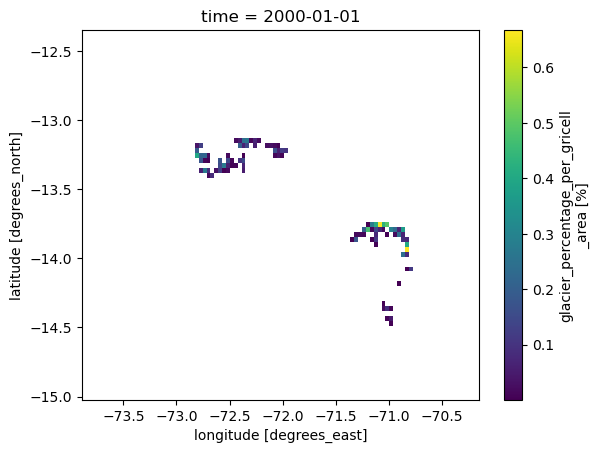

In [180]:
percent = xr.open_dataset("/home/clara/rahu_data/JULES_OGGM/historical_00_18/glacier_perc_per_gridcell.nc")
percent['percentage'][:,:,0].plot()